# Домашнее задание. Классификация изображений

Сегодня вам предстоить помочь телекомпании FOX в обработке их контента. Как вы знаете, сериал "Симпсоны" идет на телеэкранах более 25 лет, и за это время скопилось очень много видеоматериала. Персоонажи менялись вместе с изменяющимися графическими технологиями, и Гомер Симпсон-2018 не очень похож на Гомера Симпсона-1989. В этом задании вам необходимо классифицировать персонажей, проживающих в Спрингфилде. Думаю, нет смысла представлять каждого из них в отдельности.



### Установка зависимостей

In [1]:
#!pip install -U torch torchvision
#!pip install wheel==0.34.1

In [2]:
# установка подходящей версии torch

#from os.path import exists
#from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
#platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
#cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
#accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

#!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
#!pip install -q http://download.pytorch.org/whl/cu118/torch-2.1.0%2Bcu118-cp310-cp310-linux_x86_64.whl torchvision
#import torch

In [3]:
#!pip install -c anaconda tensorflow-gpu

In [4]:
# we will verify that GPU is enabled for this notebook
# following should print: CUDA is available!  Training on GPU ...
#
# if it prints otherwise, then you need to enable GPU:
# from Menu > Runtime > Change Runtime Type > Hardware Accelerator > GPU

#import torch
#import numpy as np

#train_on_gpu = torch.cuda.is_available()

#if not train_on_gpu:
#    print('CUDA is not available.  Training on CPU ...')
#else:
#    print('CUDA is available!  Training on GPU ...')

In [5]:
# нам необходима версия pillow  5.3.0
# удалим старую версию и установим новую
#!pip uninstall -y Pillow
#!pip install Pillow==5.3.0
#import PIL
#print(PIL.__version__)
# здесь должна быть версия 5.3.0. если это не так перезагрузите данный ноутбук:
# Menu > Runtime > Restart Runtime

In [6]:
#from google.colab import drive
#drive.mount('/content/gdrive/')

In [7]:
#!unzip -q /content/gdrive/My\ Drive/simpsons/data/dataset.zip -d train
#!unzip -q /content/gdrive/My\ Drive/simpsons/data/testset.zip -d test

In [8]:
#!ls train

In [9]:
#!nvidia-smi
#import torch
#torch.cuda.is_available()

In [10]:
#import torch
#print(torch.__version__)

In [11]:
#!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

В нашем тесте будет 990 картинок, для которых вам будет необходимо предсказать класс.

In [12]:
import pickle
import numpy as np
import torch
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import models, transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)


In [13]:
# разные режимы датасета
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda")

https://jhui.github.io/2018/02/09/PyTorch-Data-loading-preprocess_torchvision/


Ниже мы используем враппер над датасетом для удобной работы. Вам стоит понимать, что происходит с LabelEncoder и  с torch.Transformation.

ToTensor конвертирует  PIL Image с параметрами в диапазоне [0, 255] (как все пиксели) в FloatTensor размера (C x H x W) [0,1] , затем производится масштабирование:
$input = \frac{input - \mu}{\text{standard deviation}} $, <br>       константы - средние и дисперсии по каналам на основе ImageNet


Стоит также отметить, что мы переопределяем метод __getitem__ для удобства работы с данной структурой данных.
 Также используется LabelEncoder для преобразования строковых меток классов в id и обратно. В описании датасета указано, что картинки разного размера, так как брались напрямую с видео, поэтому следуем привести их к одному размер (это делает метод  _prepare_sample)

In [14]:
import os
import pickle
from PIL import Image
import numpy as np
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from sklearn.preprocessing import LabelEncoder

DATA_MODES = ['train', 'val', 'test']
RESCALE_SIZE = 224

class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """

    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)

        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                pickle.dump(self.label_encoder, le_dump_file)

    def __len__(self):
        return self.len_

    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image

    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        if self.mode != 'train':
            transform = transforms.Compose([
                transforms.Resize(size=(224, 224)),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [
                                     0.229, 0.224, 0.225])
            ])
            x = self.load_sample(self.files[index])
            x = transform(x)
        else:
            transform = transforms.Compose([
                transforms.Resize(size=(224, 224)),
                transforms.CenterCrop(224 * .9),
                transforms.RandomRotation(2.8),
                transforms.RandomChoice([
                    transforms.RandomHorizontalFlip(p=0.5),
                    transforms.ColorJitter(
                                        brightness=0.5, contrast=0.3, saturation=0.3, hue=0.1),
                ]),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [
                                     0.229, 0.224, 0.225])
            ])
            x = self.load_sample(self.files[index])
            x = transform(x)

        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

In [15]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [16]:
import os
from google.colab import files

files.upload()

#!rm -r $dataset

!rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle competitions download -c journey-springfield

!unzip journey-springfield.zip



Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: train/simpsons_dataset/moe_szyslak/pic_1025.jpg  
  inflating: train/simpsons_dataset/moe_szyslak/pic_1026.jpg  
  inflating: train/simpsons_dataset/moe_szyslak/pic_1027.jpg  
  inflating: train/simpsons_dataset/moe_szyslak/pic_1028.jpg  
  inflating: train/simpsons_dataset/moe_szyslak/pic_1029.jpg  
  inflating: train/simpsons_dataset/moe_szyslak/pic_1030.jpg  
  inflating: train/simpsons_dataset/moe_szyslak/pic_1031.jpg  
  inflating: train/simpsons_dataset/moe_szyslak/pic_1032.jpg  
  inflating: train/simpsons_dataset/moe_szyslak/pic_1033.jpg  
  inflating: train/simpsons_dataset/moe_szyslak/pic_1034.jpg  
  inflating: train/simpsons_dataset/moe_szyslak/pic_1035.jpg  
  inflating: train/simpsons_dataset/moe_szyslak/pic_1036.jpg  
  inflating: train/simpsons_dataset/moe_szyslak/pic_1037.jpg  
  inflating: train/simpsons_dataset/moe_szyslak/pic_1038.jpg  
  inflating: train/simpsons_dataset/moe_szyslak/pi

In [17]:
TRAIN_DIR = Path('train/simpsons_dataset')
TEST_DIR = Path('testset/testset')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [18]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)


In [19]:
val_dataset = SimpsonsDataset(val_files, mode='val')
train_dataset = SimpsonsDataset(train_files, mode='train')

In [20]:
# uncomment if you have problem with pillow
# def register_extension(id, extension): Image.EXTENSION[extension.lower()] = id.upper()
# Image.register_extension = register_extension
# def register_extensions(id, extensions):
#     for extension in extensions: register_extension(id, extension)
# Image.register_extensions = register_extensions

Давайте посмотрим на наших героев внутри датасета.

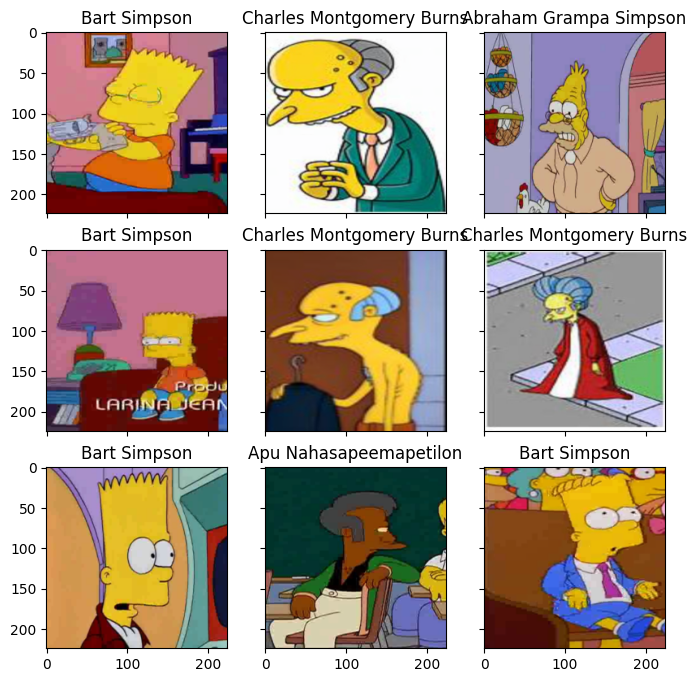

In [21]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

Можете добавить ваши любимые сцены и классифицировать их. (веселые результаты можно кидать в чат)

### Оверсамплинг

Некоторых героев в датасете мало, проведем оверсамплинг и зададим минимальное количество 400.

In [22]:
def create_dct_path_labels(train_files, train_labels):
    dct_simpsons = {}
    for label_i in np.unique(train_labels).tolist():
        dct_simpsons[label_i] = []

    for path_i, label_i in zip(train_files, train_labels):
        dct_simpsons[label_i].append(path_i)

    return dct_simpsons


# Создадим словарь в котором ключами будут персонажи Симпсонов, а значениями списки с путями к картинкам.
dct_path_train = create_dct_path_labels(train_files, train_dataset.labels)

In [23]:
# Дополним картинки классов у которых менее MIN_SIZE картинок, до MIN_SIZE картинок в классе
MIN_SIZE = 400
for person in dct_path_train:
    if len(dct_path_train[person]) < MIN_SIZE:
        dct_path_train[person] = dct_path_train[person] * \
            (MIN_SIZE // len(dct_path_train[person]))
        dct_path_train[person].extend(
            dct_path_train[person][:MIN_SIZE - len(dct_path_train[person])])


# Проверим что получилось
for person in dct_path_train:
    print(f"{person}\t{len(dct_path_train[person])}")
new_train_files = []

for person in dct_path_train:
    new_train_files.extend(dct_path_train[person])

val_dataset = SimpsonsDataset(val_files, mode='val')
new_train_dataset = SimpsonsDataset(new_train_files, mode='train')

abraham_grampa_simpson	685
agnes_skinner	400
apu_nahasapeemapetilon	467
barney_gumble	400
bart_simpson	1006
carl_carlson	400
charles_montgomery_burns	895
chief_wiggum	739
cletus_spuckler	400
comic_book_guy	400
disco_stu	400
edna_krabappel	400
fat_tony	400
gil	400
groundskeeper_willie	400
homer_simpson	1684
kent_brockman	400
krusty_the_clown	904
lenny_leonard	400
lionel_hutz	400
lisa_simpson	1015
maggie_simpson	400
marge_simpson	968
martin_prince	400
mayor_quimby	400
milhouse_van_houten	809
miss_hoover	400
moe_szyslak	1089
ned_flanders	1090
nelson_muntz	400
otto_mann	400
patty_bouvier	400
principal_skinner	895
professor_john_frink	400
rainier_wolfcastle	400
ralph_wiggum	400
selma_bouvier	400
sideshow_bob	658
sideshow_mel	400
snake_jailbird	400
troy_mcclure	400
waylon_smithers	400


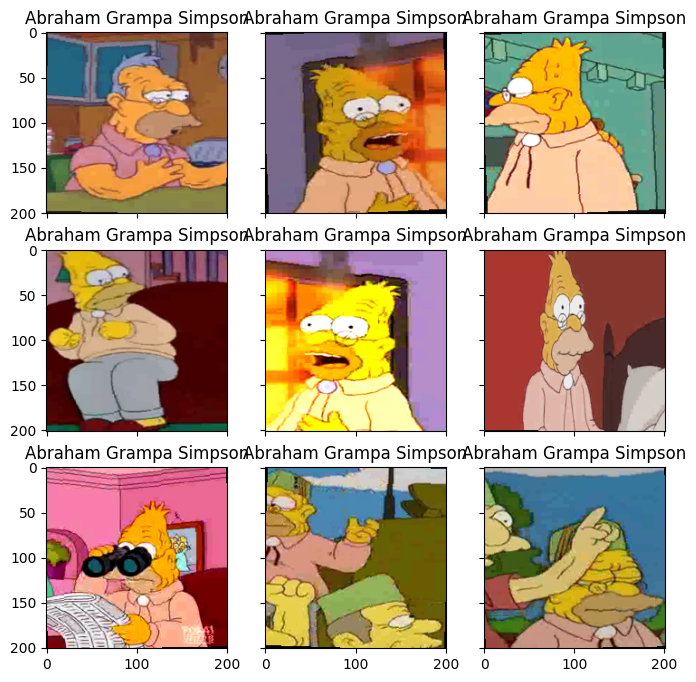

In [24]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = new_train_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                new_train_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

# Борьба с дисбалансом

In [25]:
#from sklearn.preprocessing import LabelEncoder
#import numpy as np
#import torch
#from torch.utils.data import WeightedRandomSampler

# Используем LabelEncoder для преобразования строковых меток в целочисленные
#label_encoder = LabelEncoder()
#encoded_labels = label_encoder.fit_transform(train_val_labels)

# Вычисляем количество образцов для каждого класса
#class_sample_counts = np.array([np.sum(encoded_labels == i) for i in np.unique(encoded_labels)])

# Создаем веса для каждого класса
#class_weights = 1. / torch.tensor(class_sample_counts, dtype=torch.float)

# Преобразуем закодированные метки в тензор PyTorch для индексации
#labels_tensor = torch.tensor(encoded_labels, dtype=torch.long)

# Используем labels_tensor для индексации class_weights и создания весов для каждого образца
#sample_weights = class_weights[labels_tensor]

# Создаем WeightedRandomSampler
#sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)


### Построение нейросети

Запустить данную сеть будет вашим мини-заданием на первую неделю, чтобы было проще участвовать в соревновании.

Данная архитектура будет очень простой и нужна для того, чтобы установить базовое понимание и получить простенький сабмит на Kaggle

<!-- Здесь вам предлагается дописать сверточную сеть глубины 4/5.  -->

*Описание слоев*:



1. размерность входа: 3x224x224
2.размерности после слоя:  8x111x111
3. 16x54x54
4. 32x26x26
5. 64x12x12
6. выход: 96x5x5


## Очень простая сеть

In [26]:
# Очень простая сеть
class SimpleCnn(nn.Module):

    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.out = nn.Linear(96 * 5 * 5, n_classes)


    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        x = x.view(x.size(0), -1)
        logits = self.out(x)
        return logits

In [27]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)

    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [28]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [29]:
def train(train_files, val_files, model, epochs, batch_size):
    train_loader = DataLoader(new_train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.Adam(model.parameters(), lr=1e-4)
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)

            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))

    return history

In [30]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []

        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)

    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [31]:
n_classes = len(np.unique(train_val_labels))
simple_cnn = SimpleCnn(n_classes).to(DEVICE)
print("we will classify :{}".format(n_classes))
print(simple_cnn)

we will classify :42
SimpleCnn(
  (conv1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv5): Sequential(
    (0): Conv2d(64, 96, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=2400, out_fea

Запустим обучение сети.

In [70]:
#if val_dataset is None:
#    val_dataset = SimpsonsDataset(val_files, mode='val')

#train_dataset = SimpsonsDataset(train_files, mode='train')

In [71]:
# %%time
#history = train(new_train_dataset, val_dataset, model=simple_cnn, epochs=10, batch_size=64)

Большая разница между обучающей и тренировочной выборками, сеть переобучается и дает низкую точность.

Построим кривые обучения

In [72]:
# loss, acc, val_loss, val_acc = zip(*history)

In [ ]:
#plt.figure(figsize=(15, 9))
#plt.plot(loss, label="train_loss")
#plt.plot(val_loss, label="val_loss")
#plt.legend(loc='best')
#plt.xlabel("epochs")
#plt.ylabel("loss")
#plt.show()

## Сеть Resnet18

In [35]:
model_resnet18 = models.resnet18(pretrained=True).to(DEVICE)
child_counter = 0
for child in model_resnet18.children():
    print(" child", child_counter, "is:")
    print(child)
    child_counter += 1

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 162MB/s]


 child 0 is:
Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
 child 1 is:
BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
 child 2 is:
ReLU(inplace=True)
 child 3 is:
MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
 child 4 is:
Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64

In [36]:
# Выключаем подсчет градиентов для слоев, которые не будем обучать
for i, child in enumerate(model_resnet18.children()):
    if i not in [3]:
        for param in child.parameters():
            param.requires_grad = False

model_resnet18.fc = nn.Sequential(nn.Linear(512,42))

In [37]:
model_resnet18 = model_resnet18.cuda()

In [38]:
%%time
history = train(new_train_dataset, val_dataset, model=model_resnet18, epochs=5,
#                 sampler=sampler_wht,
                batch_size=64
               )

epoch:   0%|          | 0/5 [00:00<?, ?it/s]

loss 2.984742489361185


epoch:  20%|██        | 1/5 [03:39<14:36, 219.08s/it]


Epoch 001 train_loss: 2.9847     val_loss 2.7324 train_acc 0.1719 val_acc 0.2499
loss 2.5266101141131045


epoch:  40%|████      | 2/5 [07:08<10:40, 213.63s/it]


Epoch 002 train_loss: 2.5266     val_loss 2.3546 train_acc 0.3807 val_acc 0.4287
loss 2.2171467177859183


epoch:  60%|██████    | 3/5 [10:37<07:02, 211.23s/it]


Epoch 003 train_loss: 2.2171     val_loss 2.1018 train_acc 0.4990 val_acc 0.5025
loss 1.997039900322986


epoch:  80%|████████  | 4/5 [14:06<03:30, 210.24s/it]


Epoch 004 train_loss: 1.9970     val_loss 1.9138 train_acc 0.5501 val_acc 0.5512
loss 1.829423085938171


epoch: 100%|██████████| 5/5 [17:36<00:00, 211.28s/it]


Epoch 005 train_loss: 1.8294     val_loss 1.7855 train_acc 0.5794 val_acc 0.5697
CPU times: user 17min 17s, sys: 10.7 s, total: 17min 28s
Wall time: 17min 36s


In [39]:
loss, acc, val_loss, val_acc = zip(*history)

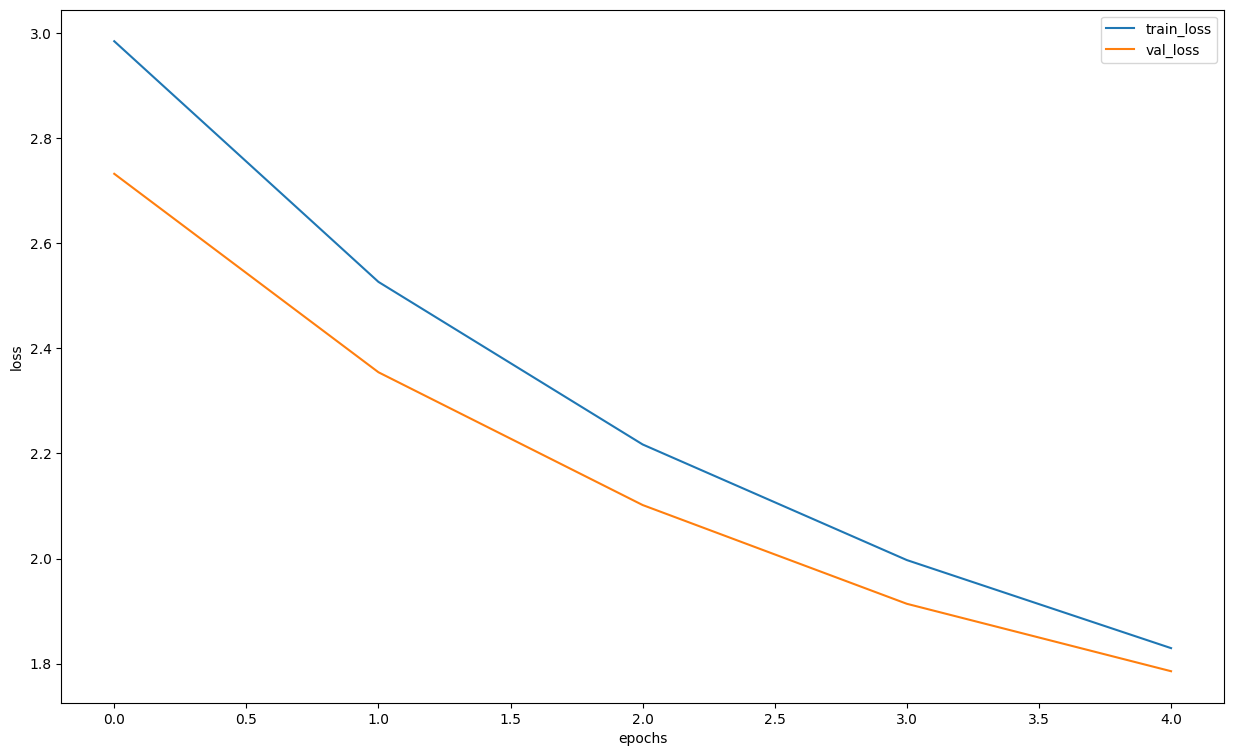

In [40]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

## Сеть VGG-16

In [41]:
model_vgg = models.vgg16(pretrained=True).to(DEVICE)
child_counter = 0
for child in model_vgg.children():
    print(" child", child_counter, "is:")
    print(child)
    child_counter += 1

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:06<00:00, 79.7MB/s]


 child 0 is:
Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 5

In [42]:
# Выключаем подсчет градиентов для слоев, которые не будем обучать
for i, child in enumerate(model_vgg.children()):
    if i not in [2]:
        for param in child.parameters():
            param.requires_grad = False

model_vgg.fc = nn.Sequential(nn.Linear(4096,42))

In [43]:
model_vgg = model_vgg.cuda()

In [44]:
%%time
history = train(new_train_dataset, val_dataset, model=model_vgg, epochs=3,
#                 sampler=sampler_wht,
                batch_size=64
               )

epoch:   0%|          | 0/3 [00:00<?, ?it/s]

loss 2.103543152177686


epoch:  33%|███▎      | 1/3 [05:17<10:34, 317.03s/it]


Epoch 001 train_loss: 2.1035     val_loss 1.2595 train_acc 0.4844 val_acc 0.6704
loss 0.7067879503089013


epoch:  67%|██████▋   | 2/3 [10:34<05:17, 317.54s/it]


Epoch 002 train_loss: 0.7068     val_loss 0.9817 train_acc 0.8165 val_acc 0.7505
loss 0.399432956292073


epoch: 100%|██████████| 3/3 [15:52<00:00, 317.34s/it]


Epoch 003 train_loss: 0.3994     val_loss 1.0034 train_acc 0.8917 val_acc 0.7503
CPU times: user 15min 38s, sys: 11.9 s, total: 15min 49s
Wall time: 15min 52s


Сеть быстро переобучается и дает низкую точность.

In [45]:
loss, acc, val_loss, val_acc = zip(*history)

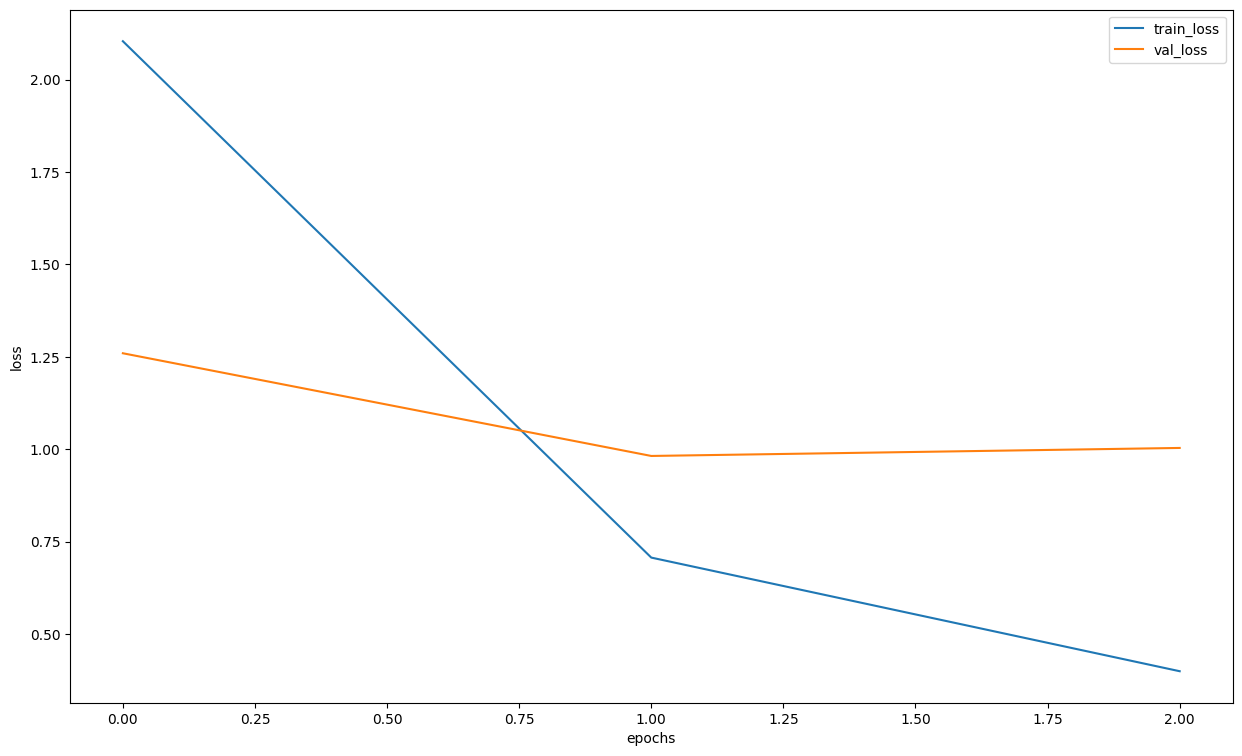

In [46]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

## Сеть Resnext101

In [47]:
model_resnext = models.resnext101_32x8d(pretrained=True).to(DEVICE)
child_counter = 0
for child in model_resnext.children():
    print(" child", child_counter, "is:")
    print(child)
    child_counter += 1

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNeXt101_32X8D_Weights.IMAGENET1K_V1`. You can also use `weights=ResNeXt101_32X8D_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnext101_32x8d-8ba56ff5.pth" to /root/.cache/torch/hub/checkpoints/resnext101_32x8d-8ba56ff5.pth
100%|██████████| 340M/340M [00:06<00:00, 59.2MB/s]


 child 0 is:
Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
 child 1 is:
BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
 child 2 is:
ReLU(inplace=True)
 child 3 is:
MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
 child 4 is:
Sequential(
  (0): Bottleneck(
    (conv1): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
    (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (downsample): Sequential(
      (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1

In [48]:
# Выключаем подсчет градиентов для слоев, которые не будем обучать
for i, child in enumerate(model_resnext.children()):
    if i not in [6]:
        for param in child.parameters():
            param.requires_grad = False

n_classes = 42

classifier = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(2048, 2048),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(2048, 2048),
    nn.ReLU(),
    nn.Linear(2048, n_classes)
)

model_resnext.fc = classifier   # nn.Sequential(nn.Linear(2048,42))

In [49]:
model_resnext = model_resnext.cuda()

In [50]:
%%time
history = train(new_train_dataset, val_dataset, model=model_resnext, epochs=3,
#                 sampler=sampler_wht,
                batch_size=64
               )

epoch:   0%|          | 0/3 [00:00<?, ?it/s]

loss 0.9595471943706679


epoch:  33%|███▎      | 1/3 [14:44<29:28, 884.30s/it]


Epoch 001 train_loss: 0.9595     val_loss 0.2978 train_acc 0.7546 val_acc 0.9263
loss 0.26463638001251094


epoch:  67%|██████▋   | 2/3 [28:49<14:21, 861.44s/it]


Epoch 002 train_loss: 0.2646     val_loss 0.2655 train_acc 0.9336 val_acc 0.9312
loss 0.1267397021148397


epoch: 100%|██████████| 3/3 [42:54<00:00, 858.07s/it]


Epoch 003 train_loss: 0.1267     val_loss 0.2110 train_acc 0.9665 val_acc 0.9513
CPU times: user 35min 38s, sys: 7min 9s, total: 42min 48s
Wall time: 42min 54s


Эта сеть показывает очень хорошую точность, будем использовать ее. Из минусов-долгое обучение. На 3 эпохи ушло 45 минут.

In [51]:
loss, acc, val_loss, val_acc = zip(*history)

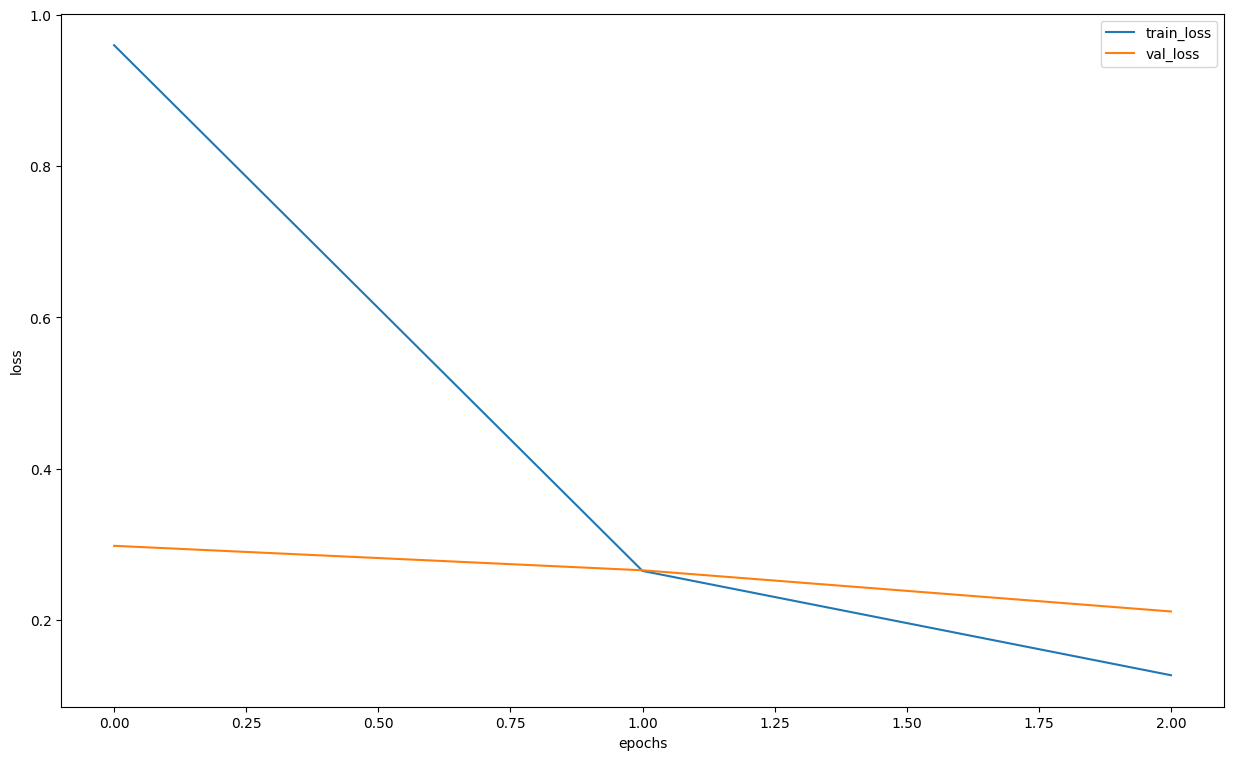

In [52]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

### Ну и что теперь со всем этим делать?

![alt text](https://www.indiewire.com/wp-content/uploads/2014/08/the-simpsons.jpg)

Хорошо бы понять, как сделать сабмит.
У нас есть сеть и методы eval у нее, которые позволяют перевести сеть в режим предсказания. Стоит понимать, что у нашей модели на последнем слое стоит softmax, которые позволяет получить вектор вероятностей  того, что объект относится к тому или иному классу. Давайте воспользуемся этим.

In [53]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [54]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(model_resnext, ex_img.unsqueeze(0))

In [55]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(model_resnext, imgs)

In [56]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [57]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

Обратите внимание, что метрика, которую необходимо оптимизировать в конкурсе --- f1-score. Вычислим целевую метрику на валидационной выборке.

In [58]:
from sklearn.metrics import f1_score

f1_score(actual_labels, y_pred, average='micro')

#f1_score(actual_labels, preds_class)

1.0

Сделаем классную визуализацию,  чтобы посмотреть насколько сеть уверена в своих ответах. Можете исспользовать это, чтобы отлаживать правильность вывода.

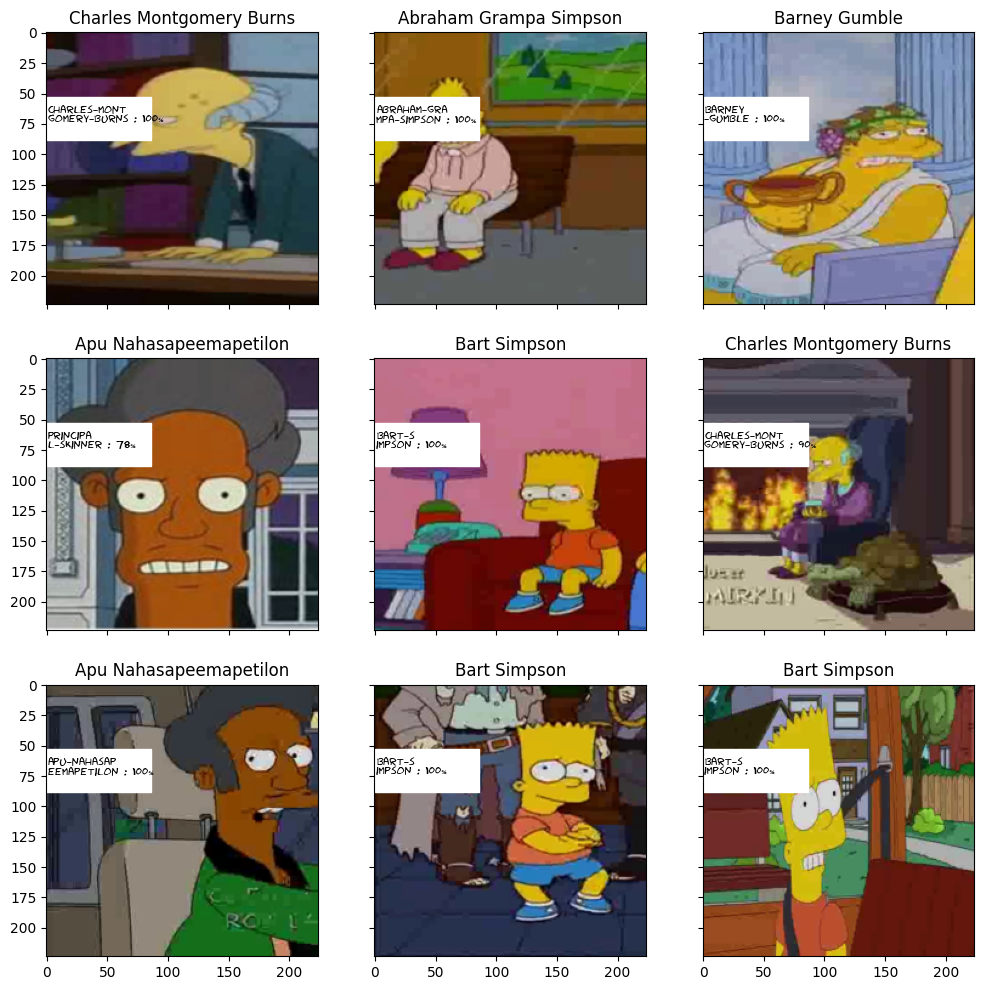

In [59]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))



    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

    actual_text = "Actual : {}".format(img_label)

    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(model_resnext, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)

    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)

    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

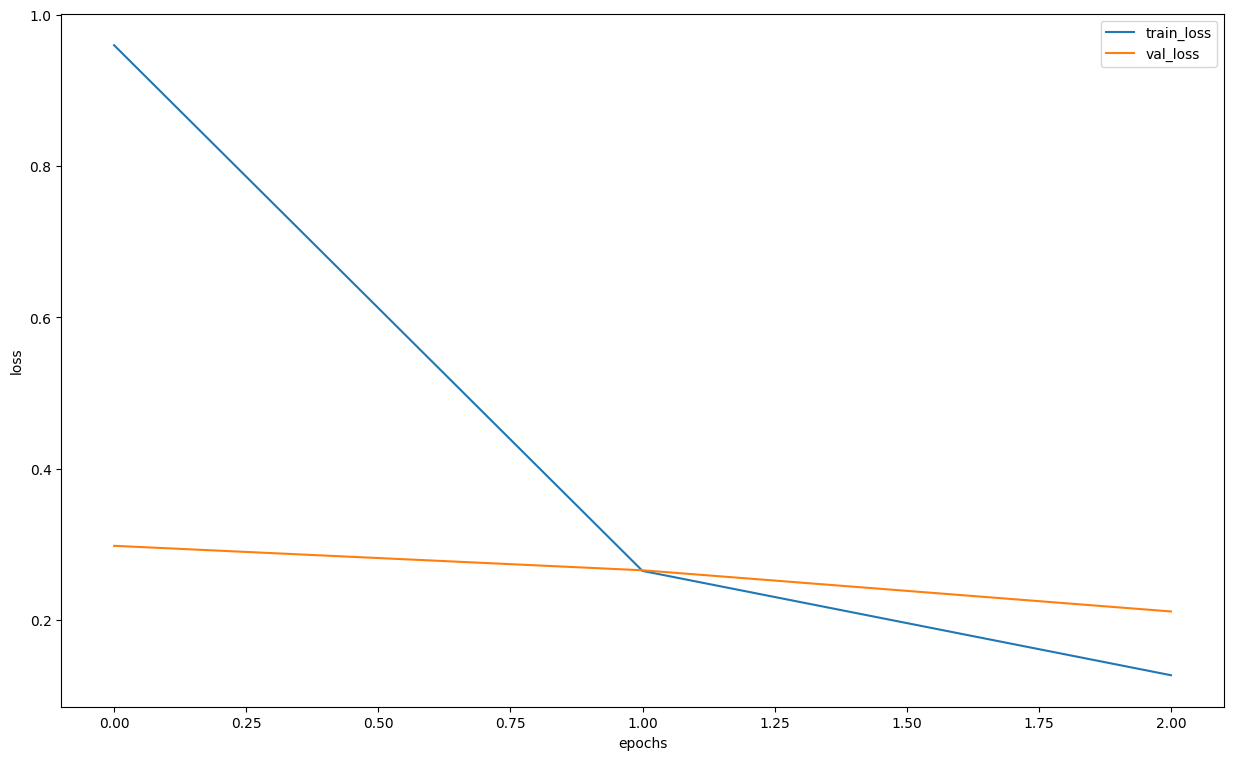

In [60]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

Попробуйте найти те классы, которые сеть не смогла расспознать. Изучите данную проблему, это понадобится в дальнейшем.

### Submit на Kaggle

![alt text](https://i.redd.it/nuaphfioz0211.jpg)

In [61]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(model_resnext, test_loader)


preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]


In [62]:
! ls

characters_illustration.png  label_encoder.pkl	sample_submission.csv  train
journey-springfield.zip      sample_data	testset


In [63]:
import pandas as pd
# my_submit = pd.read_csv("data/labels.csv")
my_submit = pd.DataFrame({'Image_id': test_filenames, 'Expected': preds})
my_submit.head()

,Image_id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon


In [64]:
# TODO : сделайте сабмит (это важно, если Вы не справляетесь, но дошли до этой ячейки, то сообщите в чат и Вам помогут)

In [91]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [92]:
%ls

characters_illustration.png  label_encoder.pkl     sample_submission.csv
drive/                       resnext_baseline.csv  testset/
journey-springfield.zip      sample_data/          train/


In [102]:
%cd drive

[Errno 2] No such file or directory: 'drive'
/content/drive


In [103]:
%ls

MyDrive/


In [105]:
my_submit.to_csv('MyDrive/resnext_baseline.csv', index=False)

In [79]:
%ls

characters_illustration.png  label_encoder.pkl     sample_data/           testset/
journey-springfield.zip      resnext_baseline.csv  sample_submission.csv  train/


*Курсив*## Приключение?

А теперь самое интересное, мы сделали простенькую сверточную сеть и смогли отправить сабмит, но получившийся скор нас явно не устраивает. Надо с этим что-то сделать.

Несколько срочныйх улучшейни для нашей сети, которые наверняка пришли Вам в голову:


*   Учим дольше и изменяем гиперпараметры сети
*  learning rate, batch size, нормализация картинки и вот это всё
*   Кто же так строит нейронные сети? А где пулинги и батч нормы? Надо добавлять
*  Ну разве Адам наше все? [adamW](https://www.fast.ai/2018/07/02/adam-weight-decay/) для практика, [статейка для любителей](https://openreview.net/pdf?id=ryQu7f-RZ) (очень хороший анализ), [наши ](https://github.com/MichaelKonobeev/adashift/) эксперименты для заинтересованных.

* Ну разве это deep learning? Вот ResNet и Inception, которые можно зафайнтьюнить под наши данные, вот это я понимаю (можно и обучить в колабе, а можно и [готовые](https://github.com/Cadene/pretrained-models.pytorch) скачать).

* Данных не очень много, можно их аугументировать и  доучититься на новом датасете ( который уже будет состоять из, как  пример аугументации, перевернутых изображений)

* Стоит подумать об ансамблях


Надеюсь, что у Вас получится!

![alt text](https://pbs.twimg.com/profile_images/798904974986113024/adcQiVdV.jpg)
